In [1]:
%matplotlib inline

In [2]:
from os import walk
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image

import theano
import theano.tensor as T
from theano.tensor.nnet.neighbours import images2neibs

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using gpu device 0: GRID K520


In [3]:
import os

# This method reads all the images in sorted order of their names and adds them to the Ims array.

def imgRead():
    Ims = np.empty(shape = (213, 256, 256), dtype = np.float32);

    for root, dirs, files in walk("./jaffe/", topdown=True):
        files.sort()   
        for i in range(0, len(files)):  
            img = Image.open(os.path.join(root, files[i]))
            Ims[i] = img
    
    return Ims

In [4]:
# Splits an image into non-overlapping square blocks of size given by (sz * sz)

def splitImage(img, sz):
    r, c = img.shape
    no_blocks = r * c / (sz * sz)
    blocks = np.empty([no_blocks, sz , sz])
    k = 0
    for i in range(0, r, sz):
        for j in range(0, c, sz):
            blocks[k] = np.array(img[i:i+sz, j:j+sz])
            k += 1
    
    return blocks

In [5]:
# Flattens each block into a vector and assigns it to the columns of a matrix X which is returned

def createX(imgs, sz):    
    i, r, c = imgs.shape
    no_blocks = r * c / (sz * sz)
    X = np.empty([i * no_blocks, sz * sz])
    k = 0
    for image in imgs:
        for block in splitImage(image, sz):
            X[k] = block.flatten()
            k += 1
    return X

In [6]:
# creating 9 PCA reconstructions (Untouched code)

def plot_mul(c, D, im_num, X_mn, num_coeffs, n_blocks):
    f, axarr = plt.subplots(3, 3)

    for i in range(3):
        for j in range(3):
            nc = num_coeffs[i*3+j]
            cij = c[:nc, n_blocks*n_blocks*im_num:n_blocks*n_blocks*(im_num+1)]
            Dij = D[:, :nc]
            plot(cij, Dij, n_blocks, X_mn, axarr[i, j])

    f.savefig('output/hw1a_{0}_im{1}.png'.format(n_blocks, im_num))
    plt.close(f)

In [7]:
# Reconstructs the image given c, D and X_mn and finally plots it

def plot(c, D, n_blocks, X_mn, ax):
    Xp = np.dot(D, c)
    
    sz = 256 / n_blocks
    Xpp = np.empty([256,256])
    
    k = 0
    for i in range(0, n_blocks):
        for j in range(0, n_blocks):
            Xpp[sz*i:sz*(i+1), sz*j:sz*(j+1)] = Xp[:, k].reshape(sz, sz)
            k += 1

    Xpr = np.tile(X_mn, (n_blocks, n_blocks)) + Xpp
    img = Image.fromarray(Xpr)
    
    ax.imshow(img)

In [32]:
# Plot the Top 16 Eigen Vectors obtained after Eigen Decomposition

def plot_top_16(D, sz, imname):
    P = D[:, :16]
    f, axarr = plt.subplots(4, 4)
    
    Y = np.empty([16, sz, sz])
    for i in range(cols):
        Y[i] = P[:, i].reshape(sz, sz)
    
    for i in range(4):
        for j in range(4):
            axarr[i,j].imshow(Y[4*i + j], cmap=plt.cm.gray)
    f.savefig(imname)
    plt.close(f)

In [24]:
def main():
    Ims = imgRead()
    
    szs = [16, 32, 64]
    num_coeffs = [range(1, 10, 1), range(3, 30, 3), range(5, 50, 5)]

    for sz, nc in zip(szs, num_coeffs):
        X = createX(Ims, sz)
        X_mn = np.mean(X, 0)
        X = X - np.repeat(X_mn.reshape(1, -1), X.shape[0], 0)
        
        _, D = np.linalg.eig(np.dot(X.T, X))
        
        c = np.dot(D.T, X.T)

        for i in range(0, 200, 10):
            plot_mul(c, D, i, X_mn.reshape((sz, sz)),
                     num_coeffs=nc, n_blocks=int(256/sz))

        plot_top_16(D, sz, imname='output/hw1a_top16_{0}.png'.format(sz))

(4096, 4096)


/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


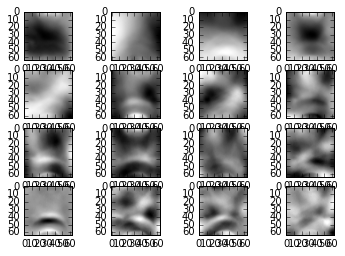

In [28]:
main()

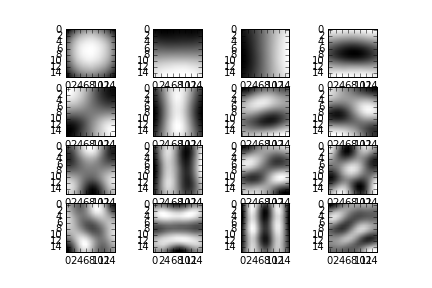

In [23]:
im = Image.open('output/hw1a_top16_16.png')
im